<a href="https://colab.research.google.com/github/alouwyck/maxsypy/blob/main/seminaries/UM6P_jan_2025/Day1/Part_9_Practical_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

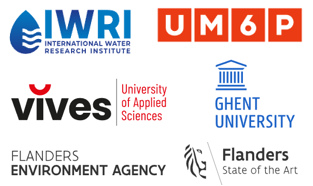<br>


**Mathematical Models and Artificial Intelligence**<br>
**for Solving Groundwater Flow Problems**<br>
Workshop organized by the<br>
International Water Research Institute (IWRI)<br>
University Mohammed VI Polytechnic<br>
January 6-7, 2025<br>
Dr. Andy Louwyck

---



<font size="6"><strong>DAY 1 - Axisymmetric Flow in Multilayer Aquifer Systems</strong></font>

---
---

# **Part 9 - A Practical Case Study**

This notebook contains the code to simulate the effect of the drainage system at the excavation site 'Duinenabdij' presented in the ninth part of the presentation. The explanation provided with the code is relatively concise. To gain a good understanding of what's going on, I recommend reading the notebook side by side with the slides.

For a detailed description of the case study and a comprehensive explanation of the application of linear programming to optimize the pumping and injection rates, I refer to Chapter 12 of [my PhD thesis](https://github.com/alouwyck/PhD) (Louwyck, 2023) and the [notebook](https://github.com/alouwyck/PhD/blob/main/chapter12_linear_programming.ipynb) with the Python code.

## 0. Import statements

We need the following libraries:
- [NumPy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/)

Importing module `inspect` will allow us to print the source code of the functions implemented in the `maxsypy` package.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import inspect

We also clone the MAxSyPy package from GitHub for simulating axisymmetric groundwater flow:

In [ ]:
import os, shutil

# remove directory 'maxsypy' first if it already exists
path = "maxsypy"
if os.path.exists(path):
    shutil.rmtree(path)

# clone maxsypy repository from Github
!git clone https://github.com/alouwyck/maxsypy


# put maxsypy package directory in the current working directory
os.rename(path, 'temp')
shutil.copytree(os.path.join('temp', path), path);
shutil.rmtree('temp')

Cloning into 'maxsypy'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 162 (delta 43), reused 0 (delta 0), pack-reused 60 (from 1)
Receiving objects: 100% (162/162), 6.69 MiB | 12.87 MiB/s, done.
Resolving deltas: 100% (77/77), done.


The [MAxSyPy](https://github.com/alouwyck/maxsypy) package implements several analytical and semi-analytical solutions discussed in my PhD thesis (Louwyck, 2023). We will also use the [TimML](https://timml.readthedocs.io/en/latest) package:

In [ ]:
!pip install timml -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.1 MB/s eta 0:00:00


In [ ]:
import timml

## 1. A drainage system of combined pumping and infiltration

In this section we simulate the effect of the drainage system at the excavation site 'Duinenabdij'. The system consists of pumping and injections wells. The total pumping rate equals the total injection rate as all the extracted groundwater is re-injected into the aquifer system. As a consequence, the system will finally reach a steady state. Therefore, we use class `Steady` to simulate the individual head change of each well. The total head change is obtained by summing all individual head changes according to the *superposition principle*.

In [ ]:
from maxsypy.multilayer import Steady

The coordinates of the pumping and injection wells.

In [ ]:
# pumping wells
pwells = np.array([ [170.61611374, 246.2633452 ],
                    [197.63033175, 237.01067616],
                    [223.93364929, 236.29893238],
                    [248.81516588, 234.87544484],
                    [278.67298578, 237.72241993],
                    [287.91469194, 259.0747331 ],
                    [296.44549763, 286.12099644],
                    [320.61611374, 289.6797153 ],
                    [345.49763033, 294.66192171],
                    [375.35545024, 302.4911032 ],
                    [400.9478673 , 307.47330961],
                    [418.00947867, 276.8683274 ],
                    [398.81516588, 243.41637011],
                    [386.72985782, 217.08185053],
                    [370.37914692, 186.47686833],
                    [351.18483412, 170.81850534],
                    [326.30331754, 155.87188612],
                    [293.60189573, 168.68327402],
                    [270.85308057, 191.45907473],
                    [248.81516588, 187.90035587],
                    [222.51184834, 181.49466192],
                    [199.0521327 , 183.62989324],
                    [181.99052133, 200.        ],
                    [162.79620853, 217.79359431],
                    [409.47867299, 292.17081851],
                    [408.41232227, 260.14234875] ])

In [ ]:
# injection wells
iwells = np.array([ [106.63507109, 261.20996441],
                    [120.14218009, 272.59786477],
                    [138.62559242, 292.52669039],
                    [145.73459716, 306.76156584],
                    [161.37440758, 318.86120996],
                    [179.85781991, 326.69039146],
                    [193.36492891, 338.79003559],
                    [212.55924171, 346.61921708],
                    [231.04265403, 355.87188612],
                    [248.1042654 , 362.27758007],
                    [260.18957346, 368.68327402],
                    [272.98578199, 381.49466192],
                    [290.04739336, 388.61209964],
                    [310.66350711, 397.86476868],
                    [330.56872038, 412.8113879 ],
                    [352.60663507, 427.75800712],
                    [375.35545024, 425.6227758 ],
                    [393.12796209, 417.08185053],
                    [411.61137441, 417.08185053],
                    [429.38388626, 423.48754448],
                    [450.        , 423.48754448],
                    [477.72511848, 417.08185053],
                    [491.23222749, 397.86476868],
                    [463.86255924, 420.28469751] ])

Plotting the wells:

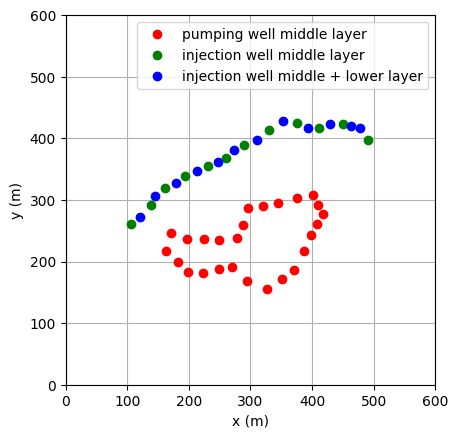

In [ ]:
plt.plot(pwells[:, 0], pwells[:, 1], 'ro', label='pumping well middle layer');
plt.plot(iwells[::2, 0], iwells[::2, 1], 'go', label='injection well middle layer');
plt.plot(iwells[1::2, 0], iwells[1::2, 1], 'bo', label='injection well middle + lower layer');

plt.xlabel('x (m)');
plt.ylabel('y (m)');
lim = (0, 600)
plt.xlim(lim);
plt.ylim(lim);
plt.grid();
plt.gca().set_aspect('equal', 'box');
plt.legend();

The original pumping and injection rates (m³/d):

In [ ]:
# pumping and injection rates
npw, niw = len(pwells), len(iwells)
print(f"{npw} pumping wells")
print(f"{niw} injection wells")
Q_grav = 4.0  # P1: discharge through gravel pack surrounding the pumping wells (upper layer)
Q_pump = 60.0  # P2: pumping rate (middle layer)
Q_deep = -40.0  # P4: deep injection rate (lower layer)
Q_inj = -(npw * (Q_pump + Q_grav) + niw / 2 * Q_deep) / niw  # P3: injection rate (middle layer)
print(f"gravel pack discharge (upper layer): {Q_grav:.2f} m³/d")
print(f"pumping rate (middle layer): {Q_pump:.2f} m³/d")
print(f"injection rate (middle layer): {Q_inj:.2f} m³/d")
print(f"injection rate (lower layer): {Q_deep:.2f} m³/d")

26 pumping wells
24 injection wells
gravel pack discharge (upper layer): 4.00 m³/d
pumping rate (middle layer): 60.00 m³/d
injection rate (middle layer): -49.33 m³/d
injection rate (lower layer): -40.00 m³/d


The aquifer system consists of three permeable layers separated by two semi-pervious layers. As we assume the flow is in a steady state, the latter can be conceptualized as incompressible zero-thickness resistance layers:

In [ ]:
# transmissivities T (m²/d) and resistances c (d)
T = [2.9 * 12, 5.2 * 13.8, 10.7 * 42.0]  # T = D * Kh
c = [1300.0, 49.70]  # confined system

Creating the superposition grid:

In [ ]:
# 600m x 600m meshgrid
n = 100
coord = np.linspace(0, 600, n)
xgrid, ygrid = np.meshgrid(coord, coord)

Defining function `euclidean` to calculate Euclidean distance between two points:

In [ ]:
euclidean = lambda x1, y1, x2, y2: np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

As the aquifer system is confined and steady flow is simulated, the system cannot be laterally unbounded. Therefore we need to define a point at a very large distance at which drawdown is zero. This is a constant-head boundary that will determine the outer model boundary of each axisymmetric model that will be used to simulate the head change due to the individual wells. Because extraction and injection are balanced and the point is at very large distance, this boundary condition will have no significant impact on the total head change.

In [ ]:
# constant-head point (x0, y0) at very large distance
x0, y0 = 1e5, 1e5

Finally, we are ready to apply the superposition method:

In [ ]:
# initializing the drawdown array
s = np.zeros((len(T), n, n))

# calculate drawdown due to each pumping well
for xy in pwells:
    x, y = tuple(xy)
    r_out = euclidean(x, y, x0, y0)  # determine the outer model boundary using (x0, y0)
    model = Steady(T=T, c=c, Q=[Q_grav, Q_pump, 0], r_out=r_out)
    r = euclidean(x, y, xgrid, ygrid)
    s += model.h(r=r.flatten()).reshape(s.shape)

# calculate the head change due to each injection well
for i, xy in enumerate(iwells):
    x, y = tuple(xy)
    r_out = euclidean(x, y, x0, y0)
    Q3 = Q_deep if i%2 else 0.0  # only half of the injection wells recharge the lower aquifer
    model = Steady(T=T, c=c, Q=[0, Q_inj, Q3], r_out=r_out)
    r = euclidean(x, y, xgrid, ygrid)
    s += model.h(r=r.flatten()).reshape(s.shape)

Plotting the result:

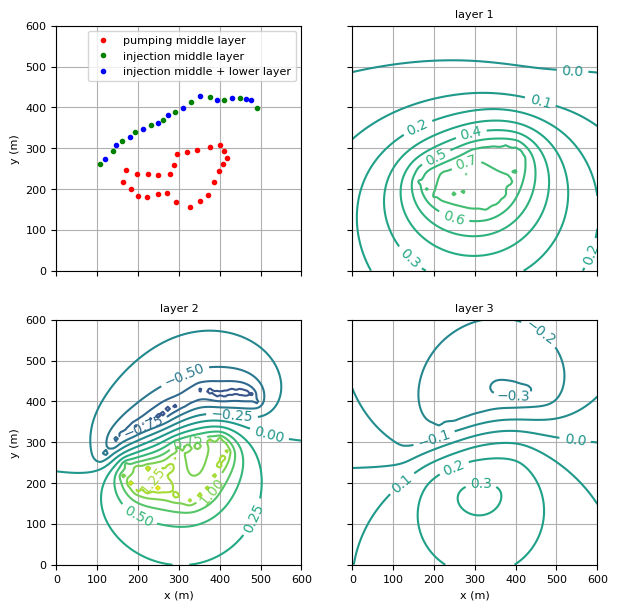

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True);

lim = (0, 600)
d = 100
fontsize = 8

ax[0][0].plot(pwells[:, 0], pwells[:, 1], 'r.', label='pumping middle layer');
ax[0][0].plot(iwells[::2, 0], iwells[::2, 1], 'g.', label='injection middle layer');
ax[0][0].plot(iwells[1::2, 0], iwells[1::2, 1], 'b.', label='injection middle + lower layer');
ax[0][0].set_xlim(lim);
ax[0][0].set_ylim(lim);
ax[0][0].set_aspect('equal', 'box');
ax[0][0].grid();

for i, a in enumerate([ax[0][1], ax[1][0], ax[1][1]]):
    step = 0.25 if i == 1 else 0.1
    cs = a.contour(xgrid, ygrid, s[i, :, :], levels=np.arange(-2, 2, step))
    a.clabel(cs, cs.levels, inline=True);
    a.set_title('layer ' + str(i+1), fontsize=fontsize);
    a.set_xlim(lim);
    a.set_ylim(lim);
    a.set_aspect('equal', 'box');
    a.grid()

ax[0][0].set_yticks(np.arange(lim[0], lim[1] + d, d));
ax[0][0].set_yticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][0].set_yticks(np.arange(lim[0], lim[1] + d, d));
ax[1][0].set_yticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][0].set_xticks(np.arange(lim[0], lim[1] + d, d));
ax[1][0].set_xticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][1].set_xticks(np.arange(lim[0], lim[1] + d, d));
ax[1][1].set_xticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[0][0].set_ylabel('y (m)', fontsize=fontsize);
ax[1][0].set_ylabel('y (m)', fontsize=fontsize);
ax[1][0].set_xlabel('x (m)', fontsize=fontsize);
ax[1][1].set_xlabel('x (m)', fontsize=fontsize);
ax[0][0].legend(fontsize=fontsize);

## 2. Using TimML to simulate the drainage system

Simulating the drainage system is very straightforward using TimML. First, we build te model by defining the aquifer system:

In [ ]:
model = timml.ModelMaq(
    z=[5, 4, 3, 2, 1, 0],  # set layer thicknesses to unity, and also include resistance layers
    kaq=T,                 # we use T as the layer thicknesses are set to unity
    c=c,                   # the resistances of the semi-pervious layers
)

Then, we add the pumping and injection wells using `for`-loops:

In [ ]:
# adding the pumping wells
for xy in pwells:
    x, y = tuple(xy)
    timml.Well(model, xw=x, yw=y, Qw=-Q_grav, layers=0)
    timml.Well(model, xw=x, yw=y, Qw=-Q_pump, layers=1)

# adding the injection wells
for i, xy in enumerate(iwells):
    x, y = tuple(xy)
    timml.Well(model, xw=x, yw=y, Qw=-Q_inj, layers=1)
    if i%2:
        timml.Well(model, xw=x, yw=y, Qw=-Q_deep, layers=2)

We cannot forget to define a constant-head condition for point `(x0,y0)` which is at a very large distance of the wells:

In [ ]:
timml.Constant(model, xr=x0, yr=y0, layer=0);

All elements are added, so we are ready to solve the model:

In [ ]:
model.solve()

Number of elements, Number of equations: 89 , 1
.........................................................................................
solution complete


Finally, we calculate the drawdown for each node in the grid:

In [ ]:
s_tim = np.array([[model.head(x, y) for x in coord] for y in coord])
s_tim.shape

(100, 100, 3)

As expected, we get the same result:

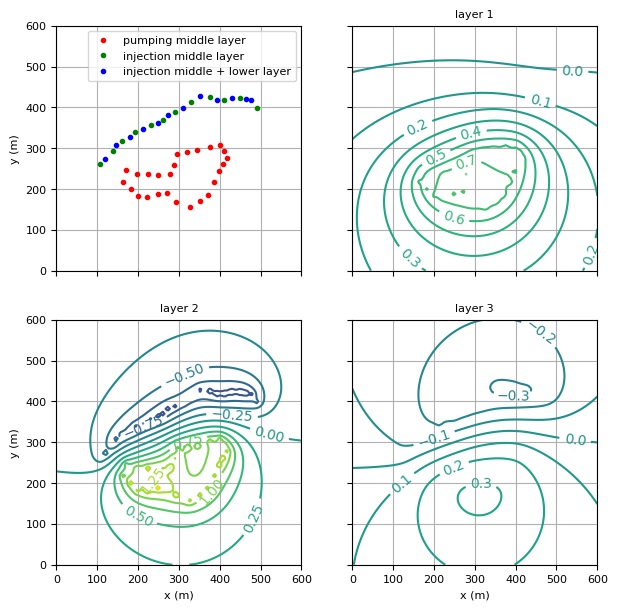

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True);

lim = (0, 600)
d = 100
fontsize = 8

ax[0][0].plot(pwells[:, 0], pwells[:, 1], 'r.', label='pumping middle layer');
ax[0][0].plot(iwells[::2, 0], iwells[::2, 1], 'g.', label='injection middle layer');
ax[0][0].plot(iwells[1::2, 0], iwells[1::2, 1], 'b.', label='injection middle + lower layer');
ax[0][0].set_xlim(lim);
ax[0][0].set_ylim(lim);
ax[0][0].set_aspect('equal', 'box');
ax[0][0].grid();

for i, a in enumerate([ax[0][1], ax[1][0], ax[1][1]]):
    step = 0.25 if i == 1 else 0.1
    cs = a.contour(xgrid, ygrid, s_tim[:, :, i], levels=np.arange(-2, 2, step))
    a.clabel(cs, cs.levels, inline=True);
    a.set_title('layer ' + str(i+1), fontsize=fontsize);
    a.set_xlim(lim);
    a.set_ylim(lim);
    a.set_aspect('equal', 'box');
    a.grid()

ax[0][0].set_yticks(np.arange(lim[0], lim[1] + d, d));
ax[0][0].set_yticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][0].set_yticks(np.arange(lim[0], lim[1] + d, d));
ax[1][0].set_yticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][0].set_xticks(np.arange(lim[0], lim[1] + d, d));
ax[1][0].set_xticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][1].set_xticks(np.arange(lim[0], lim[1] + d, d));
ax[1][1].set_xticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[0][0].set_ylabel('y (m)', fontsize=fontsize);
ax[1][0].set_ylabel('y (m)', fontsize=fontsize);
ax[1][0].set_xlabel('x (m)', fontsize=fontsize);
ax[1][1].set_xlabel('x (m)', fontsize=fontsize);
ax[0][0].legend(fontsize=fontsize);

---